# 0. Load libraries

In [5]:
import pandas as pd
import numpy as np
import modeling_functions as mf
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
# Prices
print("Loading prices data...")
url = 'https://drive.google.com/uc?id=1P_5ykYLd5521QUdCxC_cMytdJ3PqESTw'
prices = pd.read_csv("prices.csv", parse_dates=True, index_col=0)
print("✓ Loaded prices")

Loading prices data...
✓ Loaded prices


In [6]:
prices

,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753
...,...,...,...,...,...,...
2024-03-20 12:00:00,BTC,63432.0,63995.7,63211.5,63701.9,6191.443000
2024-03-20 13:00:00,BTC,64101.7,64107.1,63734.0,63764.1,2625.228000
2024-03-20 14:00:00,BTC,63640.6,63918.0,63487.3,63865.9,3102.018000


# 1. Feature Engineering

In [7]:
# Calculate Simple Moving Averages: 3-period and 12-period
sma_df = pd.DataFrame(index=prices.index)
# Lag the 'close' before calculating rolling means to avoid lookahead bias
lagged_close = prices['close'].shift(1)
sma_df['close'] = prices['close']
# Calculate lagged SMA_3 and SMA_12
sma_df['SMA_3'] = lagged_close.rolling(window=6).mean()
sma_df['SMA_12'] = lagged_close.rolling(window=24).mean()

# Compute the difference between SMA_3 and SMA_12
sma_df['MA_diff'] = sma_df['SMA_3'] - sma_df['SMA_12']

# Shift MA_diff to detect crossovers
sma_df['MA_diff_shift'] = sma_df['MA_diff'].shift(1)

# Define crossover signal: 1 for golden cross, -1 for death cross
def crossover(row):
    if row['MA_diff'] > 0 and row['MA_diff_shift'] <= 0:
        return 1   # golden cross (SMA_3 crosses above SMA_12)
    elif row['MA_diff'] < 0 and row['MA_diff_shift'] >= 0:
        return -1  # death cross (SMA_3 crosses below SMA_12)
    else:
        return 0   # no crossover

# Apply crossover detection
sma_df['SMA_signal_raw'] = sma_df.apply(crossover, axis=1)

# Forward-fill signal: carry previous signal if current is 0
sma_df['SMA_signal'] = sma_df['SMA_signal_raw'].replace(to_replace=0, method='ffill')
# Calculate rolling 6h standard deviation of lagged close (as before)
sma_df['volatility_6h'] = lagged_close.rolling(window=6).std()
# Perform rolling z-score normalization over a 48-hour window
vol_mean = sma_df['volatility_6h'].rolling(window=48).mean()
vol_std = sma_df['volatility_6h'].rolling(window=48).std()
sma_df['volatility_6h_signal'] = (sma_df['volatility_6h'] - vol_mean) / vol_std

# Update final_df to include the standardized volatility
final_df = sma_df[['close', 'SMA_3', 'SMA_12', 'SMA_signal', 'volatility_6h_signal']]
final_df['log_ret']=np.log(final_df['close']/final_df['close'].shift(1))
final_df

,close,SMA_3,SMA_12,SMA_signal,volatility_6h_signal,log_ret
date,,,,,,
2018-01-01 01:00:00,13680.0,NaN,NaN,0,NaN,NaN
2018-01-01 02:00:00,13514.0,NaN,NaN,0,NaN,-0.012209
2018-01-01 03:00:00,13560.2,NaN,NaN,0,NaN,0.003413
2018-01-01 04:00:00,13667.4,NaN,NaN,0,NaN,0.007874
2018-01-01 05:00:00,13765.0,NaN,NaN,0,NaN,0.007116
...,...,...,...,...,...,...
2024-03-20 12:00:00,63701.9,62644.800000,63151.387500,-1,-0.215392,0.009470
2024-03-20 13:00:00,63764.1,62971.450000,63158.308333,-1,-0.524426,0.000976
2024-03-20 14:00:00,63865.9,63247.100000,63173.779167,1,-1.123813,0.001595


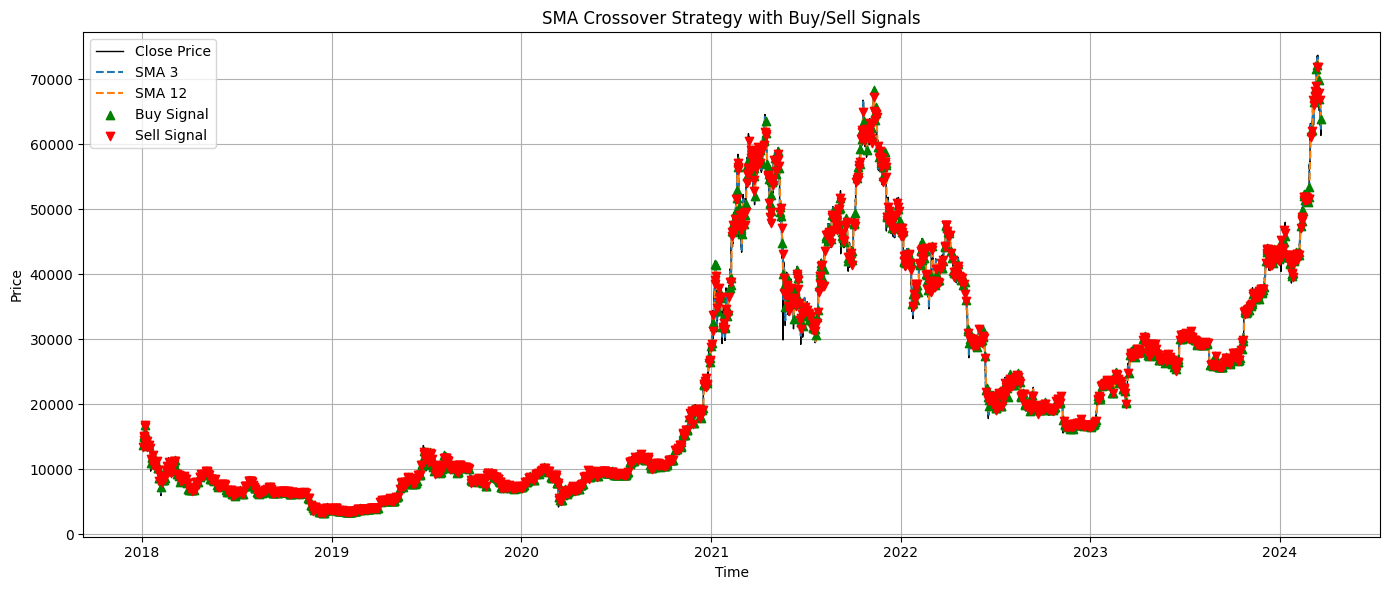

In [8]:
# Restrict the date range
start_date = '2018-01-01'
end_date = '2025-06-30'
final_df_limited = final_df.loc[start_date:end_date]
# Identify points where signal changes (crossovers)
signal_changes = final_df_limited['SMA_signal'].diff().fillna(0) != 0
buy_signals = final_df_limited[signal_changes & (final_df_limited['SMA_signal'] == 1)]
sell_signals = final_df_limited[signal_changes & (final_df_limited['SMA_signal'] == -1)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(final_df_limited.index, final_df_limited['close'], label='Close Price', color='black', linewidth=1)
plt.plot(final_df_limited.index, final_df_limited['SMA_3'], label='SMA 3', linestyle='--')
plt.plot(final_df_limited.index, final_df_limited['SMA_12'], label='SMA 12', linestyle='--')

# Mark crossover signals
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', zorder=5)

plt.title("SMA Crossover Strategy with Buy/Sell Signals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Creating Labels

In [10]:
trend_labels=pd.read_csv('trend_labels_5_20_True.csv',parse_dates=True,index_col=0)
final_df_labeled = final_df_limited.join(trend_labels[['bin']], how='left')
final_df_labeled

,close,SMA_3,SMA_12,SMA_signal,volatility_6h_signal,log_ret,bin
date,,,,,,,
2018-01-01 01:00:00,13680.0,NaN,NaN,0,NaN,NaN,1.0
2018-01-01 02:00:00,13514.0,NaN,NaN,0,NaN,-0.012209,1.0
2018-01-01 03:00:00,13560.2,NaN,NaN,0,NaN,0.003413,-1.0
2018-01-01 04:00:00,13667.4,NaN,NaN,0,NaN,0.007874,-1.0
2018-01-01 05:00:00,13765.0,NaN,NaN,0,NaN,0.007116,-1.0
...,...,...,...,...,...,...,...
2024-03-20 12:00:00,63701.9,62644.800000,63151.387500,-1,-0.215392,0.009470,NaN
2024-03-20 13:00:00,63764.1,62971.450000,63158.308333,-1,-0.524426,0.000976,NaN
2024-03-20 14:00:00,63865.9,63247.100000,63173.779167,1,-1.123813,0.001595,NaN


# 3. Model Development

## 3.1 variables selection and parameters setting

In [11]:
x_variables = final_df_labeled[['SMA_signal','volatility_6h_signal']]
y_variables = final_df_labeled['bin'].dropna(how='all')
x_variables = sm.add_constant(x_variables)  
x_variables=x_variables.dropna()
x_variables

,const,SMA_signal,volatility_6h_signal
date,,,
2018-01-03 06:00:00,1.0,1,-0.495030
2018-01-03 07:00:00,1.0,1,-0.757322
2018-01-03 08:00:00,1.0,1,0.119106
2018-01-03 09:00:00,1.0,1,-0.047376
2018-01-03 10:00:00,1.0,1,-0.032358
...,...,...,...
2024-03-20 12:00:00,1.0,-1,-0.215392
2024-03-20 13:00:00,1.0,-1,-0.524426
2024-03-20 14:00:00,1.0,1,-1.123813


In [12]:
final_df_labeled['bin']

date
2018-01-01 01:00:00    1.0
2018-01-01 02:00:00    1.0
2018-01-01 03:00:00   -1.0
2018-01-01 04:00:00   -1.0
2018-01-01 05:00:00   -1.0
                      ... 
2024-03-20 12:00:00    NaN
2024-03-20 13:00:00    NaN
2024-03-20 14:00:00    NaN
2024-03-20 15:00:00    NaN
2024-03-20 16:00:00    NaN
Name: bin, Length: 54496, dtype: float64

In [13]:
expanding_mean = pd.DataFrame(final_df.loc[start_date:,f"log_ret"].expanding(min_periods=1).mean()).dropna(how='all')
expanding_mean

,log_ret
date,
2018-01-01 02:00:00,-0.012209
2018-01-01 03:00:00,-0.004398
2018-01-01 04:00:00,-0.000307
2018-01-01 05:00:00,0.001549
2018-01-01 06:00:00,0.000977
...,...
2024-03-20 12:00:00,0.000028
2024-03-20 13:00:00,0.000028
2024-03-20 14:00:00,0.000028


In [14]:
train_start = pd.Timestamp(x_variables.index[0])
train_end = pd.Timestamp('2020-01-05 23:00:00')  #initial training period
calib_start = pd.Timestamp('2020-01-06 00:00:00') 
calib_end = pd.Timestamp('2020-5-05 23:00:00') 
test_start = calib_end + pd.DateOffset(hour=1)

## 3.2 Model training

In [16]:
# 固定训练集区间
X_train = x_variables.loc[train_start:train_end]
y_train = y_variables.loc[train_start:train_end]

# 测试集起点位置
index_position = y_variables.index.get_loc(test_start)
n_obs = len(y_variables)

In [17]:
# 可选：交叉验证调参（或直接训练模型）
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        max_features=0.6,
        class_weight='balanced'  # 加这个！
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

# 初始化记录变量
forest_results = []
feature_importance_per_step = []
correct_predictions = []
y_true_list = []
y_pred_list = []

## 3.3 Calibration: From hard to soft classification

In [18]:
# 校准集（用来拟合校准器）
X_calib = x_variables.loc[calib_start:calib_end]
y_calib = y_variables.loc[calib_start:calib_end]

# 将已训练好的模型再用校准集进行校准
calibrated_model = CalibratedClassifierCV(
    estimator=model,       
    method='sigmoid',
    cv='prefit'            
)
calibrated_model.fit(X_calib, y_calib)


CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=0.6,
                                                        min_samples_split=5,
                                                        random_state=42))

## 3.4 Model prediction

In [19]:
for t in tqdm(range(index_position, n_obs), desc="Rolling Prediction"):
    X_test = x_variables.iloc[t:t+1]
    if X_test.empty:
        continue

    y_actual = y_variables.iloc[t]
    current_date = y_variables.index[t]

    # 历史均值作为 baseline（已对其分类化）
    y_historical_mean_raw = expanding_mean.loc[X_test.index[-1]]
    y_historical_mean_val = y_historical_mean_raw.item()
    y_historical_mean = 1 if y_historical_mean_val > 0 else -1

    # 获取该时刻 LASSO 保留的特征
    selected_features = x_variables.loc[current_date].dropna().index.tolist()

    if len(selected_features) > 0:
        X_test_selected = X_test[selected_features]

        try:
            #如果是不加calibration，用下面的代码
            #y_pred = model.predict(X_test_selected)[0]
            proba = calibrated_model.predict_proba(X_test_selected)[0]
            if proba[1] > 0.51:
                y_pred = 1
            elif proba[1] < 0.49:
                y_pred = -1
            else:
                y_pred = 0  # uncertain zone


            # 记录正确性
            correct_predictions.append(int(y_actual == y_pred))
            y_true_list.append(int(y_actual))
            y_pred_list.append(int(y_pred))

            # 如果模型支持 feature importance，可以记录
            if hasattr(model, "feature_importances_"):
                feature_importance = model.feature_importances_
                feature_importance_per_step.append({
                    "Date": current_date,
                    **dict(zip(X_train[selected_features].columns, feature_importance))
                })

        except Exception as e:
            print(f"Prediction error at {current_date}: {e}")
            continue
    else:
        # fallback：使用历史均值分类结果
        y_pred = y_historical_mean
        correct_predictions.append(int(y_actual == y_pred))
        y_true_list.append(int(y_actual))
        y_pred_list.append(int(y_pred))

    forest_results.append({
        "Date": current_date,
        "ret_real": int(y_actual),
        "ret_pred": int(y_pred),
        "historical_mean": y_historical_mean,
        "accuracy": sum(correct_predictions) / len(correct_predictions)
    })


Rolling Prediction: 100%|██████████| 33957/33957 [03:43<00:00, 151.69it/s]


In [21]:
results_df = pd.DataFrame(forest_results)
results_df

,Date,ret_real,ret_pred,historical_mean,accuracy
0,2020-05-05 01:00:00,1,1,-1,1.000000
1,2020-05-05 02:00:00,1,1,-1,1.000000
2,2020-05-05 03:00:00,-1,1,-1,0.666667
3,2020-05-05 04:00:00,-1,1,-1,0.500000
4,2020-05-05 05:00:00,-1,1,-1,0.400000
...,...,...,...,...,...
33918,2024-03-18 07:00:00,-1,1,1,0.484507
33919,2024-03-18 08:00:00,-1,1,1,0.484493
33920,2024-03-18 09:00:00,-1,1,1,0.484479
33921,2024-03-18 10:00:00,-1,0,1,0.484464


# 4. Feature Importance Analysis

## 4.1 In-sample: MDI

volatility_6h_signal    0.924104
SMA_signal              0.075896
const                   0.000000
dtype: float64


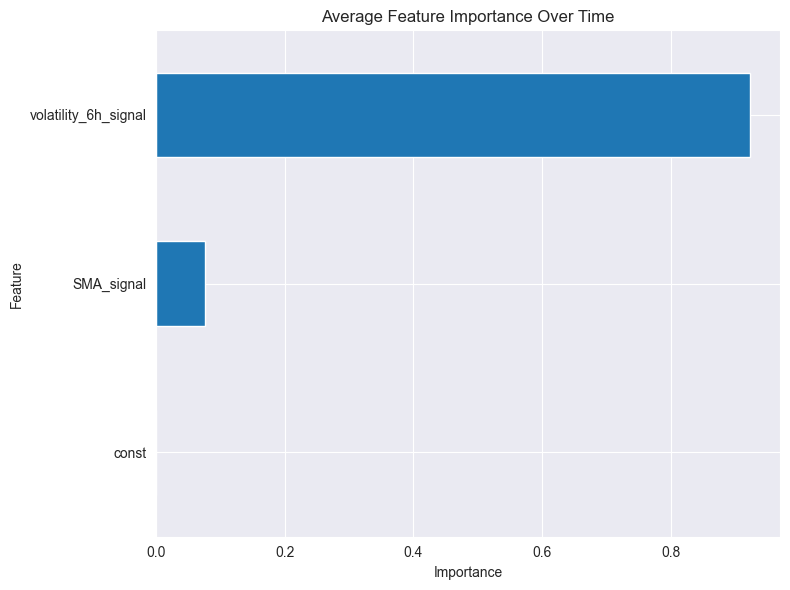

In [30]:
feature_importance_df = pd.DataFrame(feature_importance_per_step)
feature_importance_df.set_index("Date", inplace=True)
# 查看每个特征的平均重要性（跨时间）
mean_importance = feature_importance_df.mean().sort_values(ascending=False)
print(mean_importance)

mean_importance = feature_importance_df.mean().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
mean_importance.plot(kind="barh")
plt.title("Average Feature Importance Over Time")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 4.2 Out-of-sample: PFI

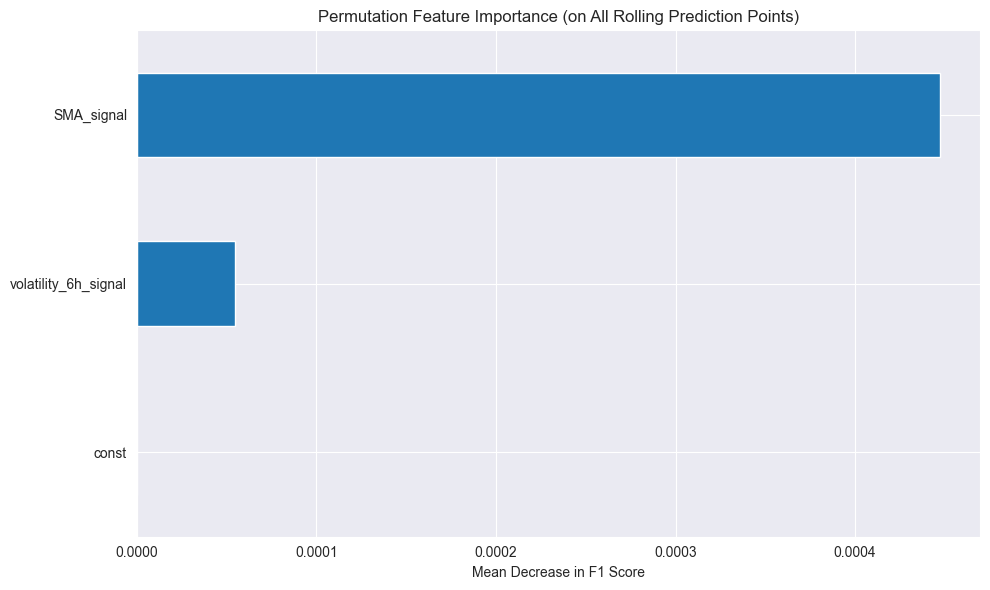

In [43]:
# 用 forest_results 的索引作为验证时间点
valid_dates = forest_results.index

# 构建验证集（特征 & 标签）
X_val_full = x_variables.loc[valid_dates]
y_val_full = y_variables.loc[valid_dates]

# 确保列顺序完全一致（与训练集相同）
X_val_full = X_val_full[X_train.columns].dropna()
y_val_full = y_val_full.loc[X_val_full.index]


result = permutation_importance(
    estimator=calibrated_model,
    X=X_val_full,
    y=y_val_full,
    n_repeats=10,
    scoring='f1',
    random_state=42
)

importances = pd.Series(result.importances_mean, index=X_val_full.columns)

plt.figure(figsize=(10, 6))
importances.sort_values(ascending=True).plot(kind="barh")
plt.title("Permutation Feature Importance (on All Rolling Prediction Points)")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()



# 5. Model Evaluation

In [35]:
# 二分类
# forest_results = pd.DataFrame(forest_results)
# 
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_true_list, y_pred_list))
# 
# print("\nClassification Report:")
# print(classification_report(y_true_list, y_pred_list, digits=4))
# 三分类

# 全部显示：混淆矩阵中保留 0 类
print("\nConfusion Matrix (with class 0 shown):")
print(confusion_matrix(y_true_list, y_pred_list, labels=[1, 0, -1]))

# 精度评估：只对 -1 和 1 做评分
print("\nClassification Report (excluding class 0):")
print(classification_report(y_true_list, y_pred_list, labels=[1, -1], digits=4))
print("\nY variable distribution")
print(y_train.value_counts(normalize=True))




Confusion Matrix (with class 0 shown):
[[16248  1189   146]
 [    0     0     0]
 [14982  1209   149]]

Classification Report (excluding class 0):
              precision    recall  f1-score   support

           1     0.5203    0.9241    0.6657     17583
          -1     0.5051    0.0091    0.0179     16340

   micro avg     0.5201    0.4834    0.5011     33923
   macro avg     0.5127    0.4666    0.3418     33923
weighted avg     0.5130    0.4834    0.3537     33923


# 6. Optional: Backtesting Performance

In [27]:
forest_results = pd.DataFrame(forest_results)
forest_results.set_index("Date", inplace=True)
log_ret_series = final_df_labeled["log_ret"]
forest_results = forest_results.join(log_ret_series, how="left")  # 按 forest_results 的索引合并
forest_results

,ret_real,ret_pred,historical_mean,accuracy,log_ret
Date,,,,,
2020-05-05 01:00:00,1,1,-1,1.000000,-0.005233
2020-05-05 02:00:00,1,1,-1,1.000000,-0.001104
2020-05-05 03:00:00,-1,1,-1,0.666667,-0.002212
2020-05-05 04:00:00,-1,1,-1,0.500000,0.008470
2020-05-05 05:00:00,-1,1,-1,0.400000,0.016342
...,...,...,...,...,...
2024-03-18 07:00:00,-1,1,1,0.483416,-0.002421
2024-03-18 08:00:00,-1,1,1,0.483402,-0.005312
2024-03-18 09:00:00,-1,1,1,0.483388,-0.004875


## 6.1 Return plots

### 6.1.1 Return plots without transaction costs

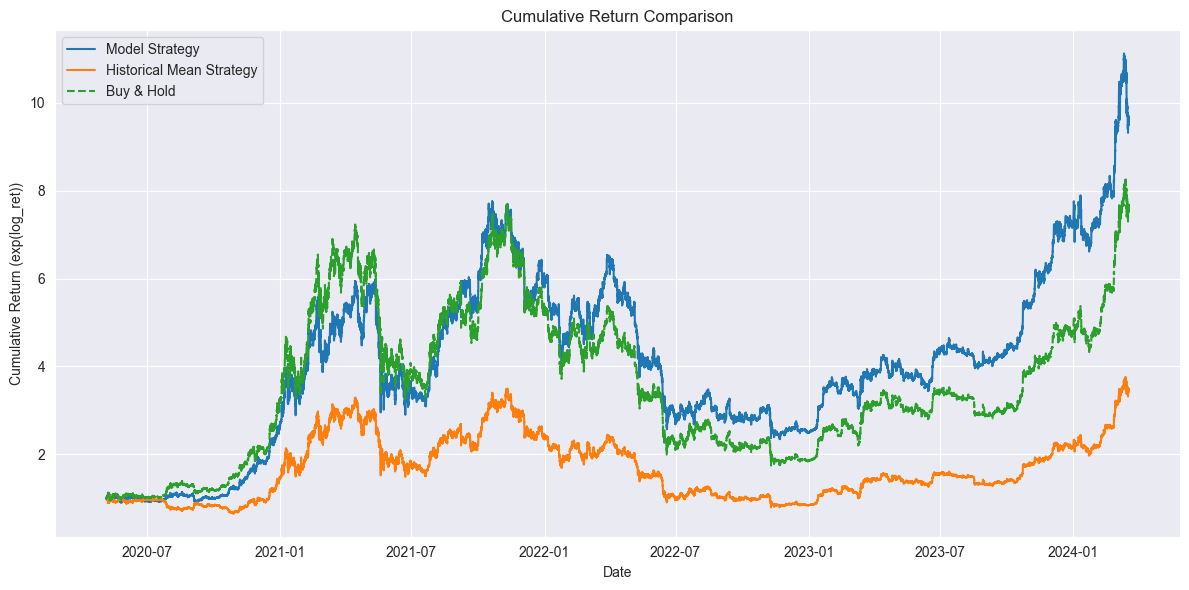

In [29]:
# Step 1: 创建新 DataFrame，索引与 forest_results 相同
returns_df = pd.DataFrame(index=forest_results.index)

# Step 2: 计算每个策略的即时收益
returns_df["strategy_ret"] = forest_results["ret_pred"] * forest_results["log_ret"]
returns_df["benchmark_ret"] = forest_results["historical_mean"] * forest_results["log_ret"]
returns_df["buy_and_hold"] = forest_results["log_ret"]

# Step 3: 计算累计收益（按 log return 累加再取 exp）
returns_df["cum_strategy_ret"] = (returns_df["strategy_ret"]).cumsum().apply(lambda x: (x)).apply(np.exp)
returns_df["cum_benchmark_ret"] = (returns_df["benchmark_ret"]).cumsum().apply(lambda x: (x)).apply(np.exp)
returns_df["cum_buy_and_hold"] = (returns_df["buy_and_hold"]).cumsum().apply(lambda x: (x)).apply(np.exp)

# Step 4: 绘图
plt.figure(figsize=(12, 6))
plt.plot(returns_df.index, returns_df["cum_strategy_ret"], label="Model Strategy")
plt.plot(returns_df.index, returns_df["cum_benchmark_ret"], label="Historical Mean Strategy")
plt.plot(returns_df.index, returns_df["cum_buy_and_hold"], label="Buy & Hold", linestyle='--')
plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (exp(log_ret))")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
forest_results

,ret_real,ret_pred,historical_mean,accuracy,log_ret
Date,,,,,
2020-05-05 01:00:00,1,1,-1,1.000000,-0.005233
2020-05-05 02:00:00,1,1,-1,1.000000,-0.001104
2020-05-05 03:00:00,-1,1,-1,0.666667,-0.002212
2020-05-05 04:00:00,-1,1,-1,0.500000,0.008470
2020-05-05 05:00:00,-1,1,-1,0.400000,0.016342
...,...,...,...,...,...
2024-03-18 07:00:00,-1,1,1,0.483416,-0.002421
2024-03-18 08:00:00,-1,1,1,0.483402,-0.005312
2024-03-18 09:00:00,-1,1,1,0.483388,-0.004875


### 6.1.2 Return plots with transaction costs

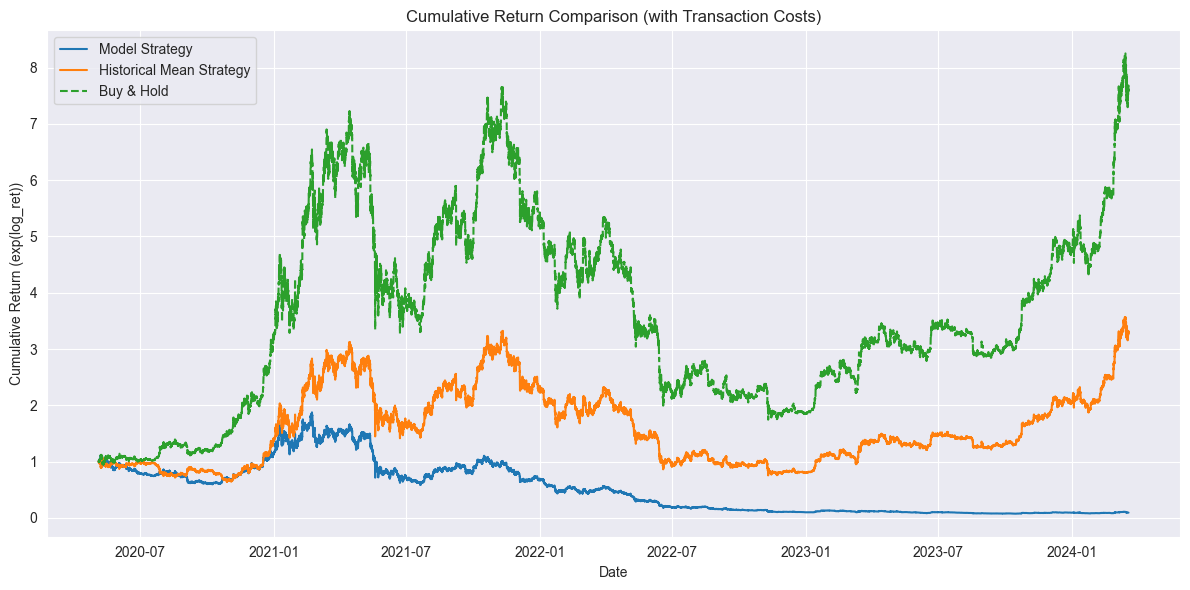

In [32]:
# 设置交易成本
transaction_cost = 0.001

# Step 1: 创建新 DataFrame，索引与 forest_results 相同
returns_df = pd.DataFrame(index=forest_results.index)

# Step 2: 添加信号列
returns_df["ret_pred"] = forest_results["ret_pred"]
returns_df["historical_mean"] = forest_results["historical_mean"]
returns_df["log_ret"] = forest_results["log_ret"]

# Step 3: 计算仓位变化（第一个为 0）
returns_df["strategy_position_change"] = (
    (returns_df["ret_pred"] != returns_df["ret_pred"].shift(1)).astype(int) +
    ((returns_df["ret_pred"] * returns_df["ret_pred"].shift(1)) == -1).astype(int)
).fillna(0).astype(int)

returns_df["historical_position_change"] = (
    (returns_df["historical_mean"] != returns_df["historical_mean"].shift(1)).astype(int) +
    ((returns_df["historical_mean"] * returns_df["historical_mean"].shift(1)) == -1).astype(int)
).fillna(0).astype(int)

# Step 4: 计算即时收益（扣除交易成本）
returns_df["strategy_ret"] = returns_df["ret_pred"] * returns_df["log_ret"] - transaction_cost * returns_df["strategy_position_change"]
returns_df["benchmark_ret"] = returns_df["historical_mean"] * returns_df["log_ret"] - transaction_cost * returns_df["historical_position_change"]
returns_df["buy_and_hold"] = returns_df["log_ret"]

# Step 5: 计算累计收益（按 log return 累加再取 exp）
returns_df["cum_strategy_ret"] = returns_df["strategy_ret"].cumsum().apply(np.exp)
returns_df["cum_benchmark_ret"] = returns_df["benchmark_ret"].cumsum().apply(np.exp)
returns_df["cum_buy_and_hold"] = returns_df["buy_and_hold"].cumsum().apply(np.exp)

# Step 6: 绘图
plt.figure(figsize=(12, 6))
plt.plot(returns_df.index, returns_df["cum_strategy_ret"], label="Model Strategy")
plt.plot(returns_df.index, returns_df["cum_benchmark_ret"], label="Historical Mean Strategy")
plt.plot(returns_df.index, returns_df["cum_buy_and_hold"], label="Buy & Hold", linestyle='--')
plt.title("Cumulative Return Comparison (with Transaction Costs)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (exp(log_ret))")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6.2 Strategy performance matrices

In [36]:
# 年化无风险收益率（3%），换算为每小时
annual_risk_free_rate = 0.03
hourly_risk_free_rate = np.log(1 + annual_risk_free_rate) / (252 * 24)  # 假设252个交易日 × 每天24小时

def calculate_sharpe_ratio(hourly_returns, risk_free_rate=hourly_risk_free_rate):
    """计算年化Sharpe Ratio"""
    excess_returns = hourly_returns - risk_free_rate
    annualized_excess_return = excess_returns.mean() * 252 * 24
    annualized_std = hourly_returns.std() * np.sqrt(252 * 24)
    return annualized_excess_return / annualized_std if annualized_std != 0 else np.nan

def calculate_max_drawdown(cumulative_returns):
    """计算最大回撤"""
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_win_rate(returns):
    """胜率（正收益比例）"""
    return (returns > 0).sum() / len(returns)


In [37]:
results_summary = {}

for strategy_name in ["strategy_ret", "benchmark_ret", "buy_and_hold"]:
    ret = returns_df[strategy_name]
    cum_ret = ret.cumsum().apply(np.exp)

    sharpe = calculate_sharpe_ratio(ret)
    drawdown = calculate_max_drawdown(cum_ret)
    win_rate = calculate_win_rate(ret)

    results_summary[strategy_name] = {
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown,
        "Win Rate": win_rate
    }

# 展示结果
summary_df = pd.DataFrame(results_summary).T
print(summary_df)


               Sharpe Ratio  Max Drawdown  Win Rate
strategy_ret      -0.846104     -0.961138  0.464552
benchmark_ret      0.324735     -0.773097  0.503375
buy_and_hold       0.589890     -0.773097  0.508180
